In [ ]:
# -*- coding: utf-8 -*-
"""test_IOT_GAME.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1vMfNvFcAijg02oQKecgxGTGtD3YZxvHa
"""

# -*- coding: utf-8 -*-
"""ES-Project-36.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1Py_yFddPwIyjlM9q-c5wx_GQ8Gq5IiwT
"""

!pip install numpy matplotlib

import numpy as np
import random
import matplotlib.pyplot as plt
import time
import pandas as pd

import numpy as np
import random
import time
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm


edge_node_count = 110

# Global variables to store resource usage for each edge node and algorithm
cpu_usage_per_edge = {i: {"Centralized": 0, "Distributed": 0, "Min-Min": 0, "Max-Min": 0, "PBSM": 0} for i in range(edge_node_count)}
ram_usage_per_edge = {i: {"Centralized": 0, "Distributed": 0, "Min-Min": 0, "Max-Min": 0, "PBSM": 0} for i in range(edge_node_count)}
bandwidth_usage_per_edge = {i: {"Centralized": 0, "Distributed": 0, "Min-Min": 0, "Max-Min": 0, "PBSM": 0} for i in range(edge_node_count)}


def reset_edge_resources(edge_nodes, iot_devices):
    """
    Resets available resources for edge nodes before scheduling.
    Ensures that per-link bandwidth W_{ae} and latency N_{ea} are preserved.

    Args:
        edge_nodes (list): List of edge nodes.
        iot_devices (list): List of IoT devices.
    """

    for node in edge_nodes:
        # ✅ Reset available resources to their initial values
        node["available_cpu"] = node["cpu"]
        node["available_ram"] = node["ram"]

    # ✅ DO NOT reinitialize per-link bandwidth and latency!
    # They were already assigned in initialize_iot_devices and should remain unchanged.

    print("🔄 Edge resources reset to initial values (CPU, RAM).")

import numpy as np  # Ensure numpy is imported for distributions

def initialize_edge_nodes(num_nodes):
    """
    Initializes edge nodes with:
    - CPU: [3000, 9000] MIPS (uniform distribution)
    - RAM: [6000, 25000] MB (uniform distribution)
    - Latency: Edge-to-Edge Communication Latency: [200, 6000] ms (uniform distribution)
    - Bandwidth: Edge-to-Edge Bandwidth Capacity: [9000, 25000] Mbps (uniform distribution)
    """
    edge_nodes = []
    for i in range(num_nodes):
        # Use uniform distribution to generate CPU and RAM within the specified ranges
        cpu = np.random.uniform(3000, 9000)  # Uniform distribution between 3000 and 9000
        ram = np.random.uniform(6000, 25000)  # Uniform distribution between 6000 and 25000

        edge_node = {
            "id": i,
            "cpu": cpu,
            "ram": ram,
            "available_cpu": cpu,  # Available CPU = Total CPU
            "available_ram": ram,  # Available RAM = Total RAM
            "latency": np.random.uniform(200, 6000),  # Uniform distribution for latency
            "edge_bandwidth": {},  # Edge-to-Edge Bandwidth W_{ee'}
        }

        # Initialize edge-to-edge bandwidth W_{ee'} for all other edge nodes
        for j in range(num_nodes):
            if i != j:
                # Use uniform distribution for edge-to-edge bandwidth
                edge_node["edge_bandwidth"][j] = np.random.uniform(9000, 25000)  # Bandwidth between 9000 and 25000 Mbps

        edge_nodes.append(edge_node)

    return edge_nodes


def initialize_iot_devices(num_devices, edge_nodes):
    """
    Initializes IoT devices with:
    - CPU: [400, 800] MIPS (uniform distribution)
    - RAM: [500, 1000] MB (uniform distribution)
    - IoT-to-Edge Bandwidth Capacity: [600, 1000] Mbps (uniform distribution)
    - Per-Link Latency and Bandwidth for Each Edge Node (uniform distribution)
    """
    iot_devices = []

    for i in range(num_devices):
        device = {
            "id": i,
            "cpu": np.random.uniform(400, 800),  # Uniform distribution for CPU between 400 and 800 MIPS
            "ram": np.random.uniform(500, 1000),  # Uniform distribution for RAM between 500 and 1000 MB
            "link_bandwidth": {},  # W_{ae} stored per-link
            "link_latency": {},  # N_{ea} stored per-link
        }

        # Assign per-link values to every edge node (done once)
        for edge in edge_nodes:
            device["link_bandwidth"][edge["id"]] = np.random.uniform(600, 1000)  # W_{ae} (per link)
            device["link_latency"][edge["id"]] = np.random.uniform(200, 6000)  # N_{ea} (per link)

        iot_devices.append(device)

    return iot_devices



# --------- COST CALCULATIONS ---------

def operational_cost(edge_node):
    return edge_node["cpu"] + edge_node["ram"]  # Oc(e) = RAMe + CPUe


def traffic_cost(iot_device, edge_node, edge_nodes):
    """
    Corrected Traffic Cost Calculation based on Eq. (2).
    - Uses per-link IoT-to-Edge bandwidth W_{ae} and latency N_{ea}.
    - Uses Edge-to-Edge bandwidth W_{ee'} for inter-node communication.
    """

    # ✅ Step 1: Fetch per-link IoT-to-Edge values
    W_ae = iot_device["link_bandwidth"][edge_node["id"]]  # IoT-to-Edge Bandwidth
    N_ea = iot_device["link_latency"][edge_node["id"]]  # IoT-to-Edge Latency

    # ✅ Step 2: Compute IoT-to-Edge traffic cost: W_ae * B_ae (Only if assigned)
    iot_to_edge_traffic_cost = W_ae

    # ✅ Step 3: Compute Edge-to-Edge communication cost: W_{ee'} * N_{ea}
    inter_edge_traffic_cost = sum(
        edge_node["edge_bandwidth"][other_edge["id"]] * N_ea  # ✅ Correctly using W_{ee'} now
        for other_edge in edge_nodes if edge_node["id"] != other_edge["id"]
    )

    # ✅ Step 4: Compute total traffic cost (Tc(e))
    total_traffic_cost = iot_to_edge_traffic_cost + inter_edge_traffic_cost

    return total_traffic_cost





def generalized_objective(iot_device, edge_node, edge_nodes):
    oc = operational_cost(edge_node)
    tc = traffic_cost(iot_device, edge_node, edge_nodes)
    return oc + tc  # T(e) = O_c(e) + T_c(e)


def generate_iot_preferences(iot_device, edge_nodes):
    """
    Generates preference list L(a) for an IoT device based on Algorithm 1.
    - Iterates through all edge nodes and verifies if they have sufficient resources.
    - Notes latency values for eligible edge nodes.
    - After exploring all edge nodes, sorts them using Eq. (12) for ranking.
    """

    explored_edges = []  # Stores valid edge nodes before ranking

    # ✅ Step 3: Explore all edge nodes
    for edge_node in edge_nodes:
        # ✅ Step 5: Check if the edge node has enough resources
        if (edge_node["available_cpu"] >= iot_device["cpu"] and
            edge_node["available_ram"] >= iot_device["ram"]):

            # ✅ Step 6: Compute Traffic Cost (Tc(e))
            tc = traffic_cost(iot_device, edge_node, edge_nodes)

            # ✅ Step 6: Store Latency (N_ea)
            latency = iot_device["link_latency"][edge_node["id"]]

            # ✅ Step 7: Store Edge Node if it has enough resources
            explored_edges.append((edge_node["id"], tc, latency, edge_node["available_cpu"] + edge_node["available_ram"]))

    # ✅ Step 9: After exploring all edge nodes, rank them using Eq. (12)
    if explored_edges:
        min_tc = min(tc for _, tc, _, _ in explored_edges)  # Get lowest traffic cost
        max_resources = max(res for _, _, _, res in explored_edges)  # Get max available resources

        ranked_edges = []
        for edge_id, tc, latency, available_resources in explored_edges:
            if tc == min_tc and available_resources == max_resources:
                preference_value = float("+inf")  # Best match
            elif tc == min_tc or available_resources == max_resources:
                preference_value = 0  # Acceptable match
            else:
                preference_value = float("-inf")  # Unacceptable match

            ranked_edges.append((edge_id, preference_value, latency))

        # ✅ Step 10: Sort edge nodes using Eq. (12) – **Rank first by preference, then by latency (lower is better)**
        ranked_edges.sort(key=lambda x: (x[1], -x[2]), reverse=True)
        # print(ranked_edges)

        # ✅ Extract sorted edge node IDs
        sorted_edge_nodes = [node_id for node_id, _, _ in ranked_edges]
    else:
        sorted_edge_nodes = []

    # # ✅ Debugging: Print Preferences for Verification
    # print(f"🔍 IoT Device {iot_device['id']} Preferences: {sorted_edge_nodes}")

    return sorted_edge_nodes


def generate_edge_preferences(edge_node, iot_devices):
    """
    Generates preference list L(e) for an edge node based on Algorithm 2.
    - Uses per-link bandwidth W_{ae} and latency N_{ea}.
    """

    preferences = []

    for iot_device in iot_devices:
        if (edge_node["available_cpu"] >= iot_device["cpu"] and
            edge_node["available_ram"] >= iot_device["ram"]):

            remaining_resources = (
                (edge_node["available_cpu"] - iot_device["cpu"]) +
                (edge_node["available_ram"] - iot_device["ram"])
            )

            preferences.append((iot_device["id"], remaining_resources))

    preferences.sort(key=lambda x: x[1])
    return [device_id for device_id, _ in preferences]


def min_min_matching(iot_devices, edge_nodes):
    global cpu_usage_per_edge, ram_usage_per_edge, bandwidth_usage_per_edge

    # Sort tasks by CPU requirements (task duration) first
    tasks = sorted(iot_devices, key=lambda x: x['cpu'])

    for task in tasks:
        # Select edge nodes that can handle the task's CPU and RAM requirements
        eligible_nodes = [n for n in edge_nodes if n['available_cpu'] >= task['cpu'] and n['available_ram'] >= task['ram']]

        # If no eligible nodes, skip the task (or handle it as required)
        if not eligible_nodes:
            print(f"⚠️ No eligible edge nodes for task {task['id']}")
            continue  # Skip this task or handle it as per the algorithm's requirements

        # Choose the best node based on the minimum traffic cost among eligible nodes
        best_node = min(eligible_nodes, key=lambda n: traffic_cost(task, n, edge_nodes))

        # Update resource usage
        best_node['available_cpu'] -= task['cpu']
        best_node['available_ram'] -= task['ram']

        # Track global resource usage per edge node
        cpu_usage_per_edge[best_node['id']]["Min-Min"] += task['cpu']
        ram_usage_per_edge[best_node['id']]["Min-Min"] += task['ram']
        bandwidth_usage_per_edge[best_node['id']]["Min-Min"] += task["link_bandwidth"][best_node["id"]]

        task['assigned_node'] = best_node['id']

    return iot_devices, edge_nodes



def max_min_matching(iot_devices, edge_nodes):
    global cpu_usage_per_edge, ram_usage_per_edge, bandwidth_usage_per_edge

    # Sort tasks by CPU requirements in descending order (task duration)
    tasks = sorted(iot_devices, key=lambda x: -x['cpu'])

    for task in tasks:
        # Select edge nodes that can handle the task's CPU and RAM requirements
        eligible_nodes = [n for n in edge_nodes if n['available_cpu'] >= task['cpu'] and n['available_ram'] >= task['ram']]
        # If no eligible nodes, skip the task (or handle it as required)
        if not eligible_nodes:
            print(f"⚠️ No eligible edge nodes for task {task['id']}")
            continue  # Skip this task or handle it as per the algorithm's requirements

        # Choose the best node based on the minimum traffic cost among eligible nodes
        best_node = min(eligible_nodes, key=lambda n: traffic_cost(task, n, edge_nodes))

        # Update resource usage
        best_node['available_cpu'] -= task['cpu']
        best_node['available_ram'] -= task['ram']

        # Track global resource usage per edge node
        cpu_usage_per_edge[best_node['id']]["Max-Min"] += task['cpu']
        ram_usage_per_edge[best_node['id']]["Max-Min"] += task['ram']
        bandwidth_usage_per_edge[best_node['id']]["Max-Min"] += task["link_bandwidth"][best_node["id"]]

        task['assigned_node'] = best_node['id']

    return iot_devices, edge_nodes



def pbsm_algorithm(iot_devices, edge_nodes):
    """
    Preference-Based Stable Matching (PBSM) Algorithm.
    - Matches IoT devices to edge nodes based on preferences.
    - Fully aligned with Algorithm 6 from the paper.
    """
    global cpu_usage_per_edge, ram_usage_per_edge, bandwidth_usage_per_edge

    # ✅ Step 1: Initialize Matching Data Structures
    A_prime = list(iot_devices)  # ✅ A' = A (All IoT devices start unassigned)
    Delta = {node["id"]: None for node in edge_nodes}  # ✅ Δ = No initial assignments

    print("Starting PBSM Algorithm...")

    # ✅ Step 2: While there are unassigned IoT devices
    while A_prime:
        # ✅ Step 3: Pick a random unmatched IoT device (a*)
        a_star = random.choice(A_prime)
        A_prime.remove(a_star)  # Remove from A'

        # ✅ Step 4: Get a*'s most preferred edge node (e*)
        if not a_star["preferences"]:  # No available edges
            print(f"🔴 IoT Device {a_star['id']} has no valid preferences! Skipping...")
            continue  # Let it remain unmatched

        e_star_id = a_star["preferences"][0]  # ✅ Extract top-ranked edge node
        e_star = next(n for n in edge_nodes if n["id"] == e_star_id)

        # ✅ Step 5: If e* is free, assign IoT device a* to e*
        if Delta[e_star["id"]] is None:
            Delta[e_star["id"]] = a_star["id"]
            a_star["assigned_node"] = e_star["id"]
            print(f"✅ IoT Device {a_star['id']} assigned to Edge Node {e_star['id']}")

            cpu_usage_per_edge[e_star["id"]]["PBSM"] += a_star['cpu']
            ram_usage_per_edge[e_star["id"]]["PBSM"] += a_star['ram']
            bandwidth_usage_per_edge[e_star["id"]]["PBSM"] += a_star["link_bandwidth"][e_star["id"]]


        else:
            # ✅ Step 6: If e* is already assigned, compare preferences
            current_a_id = Delta[e_star["id"]]
            current_a = next(d for d in iot_devices if d["id"] == current_a_id)

            # ✅ Step 7: If a* is more preferred, swap assignments
            if e_star["preferences"].index(a_star["id"]) < e_star["preferences"].index(current_a["id"]):
                Delta[e_star["id"]] = a_star["id"]
                a_star["assigned_node"] = e_star["id"]

                # Requeue the displaced IoT device
                current_a["assigned_node"] = None
                A_prime.append(current_a)  # ✅ Append back to list

                print(f"🔄 IoT Device {a_star['id']} swapped with IoT Device {current_a['id']} for Edge Node {e_star['id']}")
                # Update global usage variables for PBSM
                cpu_usage_per_edge[e_star["id"]]["PBSM"] += a_star['cpu']
                ram_usage_per_edge[e_star["id"]]["PBSM"] += a_star['ram']
                bandwidth_usage_per_edge[e_star["id"]]["PBSM"] += a_star["link_bandwidth"][e_star["id"]]


    # print("✅ PBSM Algorithm completed.")
    return Delta





def centralized_matching(edge_nodes, iot_devices):
    global cpu_usage_per_edge, ram_usage_per_edge, bandwidth_usage_per_edge
    preferences = {edge_node['id']: generate_edge_preferences(edge_node, iot_devices) for edge_node in edge_nodes}
    matches = {edge_node['id']: [] for edge_node in edge_nodes}
    unmatched_devices = list(device['id'] for device in iot_devices)
    remaining_resources = {node['id']: {'cpu': node['available_cpu'], 'ram': node['available_ram']} for node in edge_nodes}

    while unmatched_devices:
        for edge_node in edge_nodes:
            if not unmatched_devices:
                break

            current_preferences = preferences[edge_node['id']]
            for device_id in current_preferences:
                if device_id not in unmatched_devices:
                    continue

                device = next(device for device in iot_devices if device['id'] == device_id)
                if remaining_resources[edge_node['id']]['cpu'] >= device['cpu'] and remaining_resources[edge_node['id']]['ram'] >= device['ram']:
                    matches[edge_node['id']].append(device_id)
                    unmatched_devices.remove(device_id)
                    remaining_resources[edge_node['id']]['cpu'] -= device['cpu']
                    remaining_resources[edge_node['id']]['ram'] -= device['ram']
                    device['assigned_node'] = edge_node['id']  # Assign the edge node to the IoT device
                    # Update global usage variables for centralized
                    cpu_usage_per_edge[edge_node['id']]["Centralized"] += device['cpu']
                    ram_usage_per_edge[edge_node['id']]["Centralized"] += device['ram']
                    bandwidth_usage_per_edge[edge_node['id']]["Centralized"] += device["link_bandwidth"][edge_node["id"]]

                else:
                    break
    return matches

# Simulate IoT Devices sending proposals
def send_proposals(iot_devices, edge_nodes):
    for iot in iot_devices:
        for edge_id in iot['preferences']:
            # Check if 'proposals' key exists in the edge node dictionary, initialize if not
            if 'proposals' not in edge_nodes[edge_id]:
                edge_nodes[edge_id]['proposals'] = []
            edge_nodes[edge_id]['proposals'].append(iot)

# Edge Nodes processing proposals
def process_proposals(edge_nodes):
    global cpu_usage_per_edge, ram_usage_per_edge, bandwidth_usage_per_edge
    matches = {}
    for edge in edge_nodes:
        while edge['proposals']:
            iot = edge['proposals'].pop(0)  # Get the first proposal
            if edge['available_cpu'] >= iot['cpu'] and edge['available_ram'] >= iot['ram']:
                edge['available_cpu'] -= iot['cpu']
                edge['available_ram'] -= iot['ram']
                matches[iot['id']] = edge['id']

                # Update resource usage for distributed algorithm
                cpu_usage_per_edge[edge['id']]["Distributed"] += iot['cpu']
                ram_usage_per_edge[edge['id']]["Distributed"] += iot['ram']
                bandwidth_usage_per_edge[edge['id']]["Distributed"] += iot["link_bandwidth"][edge["id"]]


                break  # Stop processing as edge node accepts only one IoT device
    return matches

In [ ]:
# --------- EXPERIMENT EXECUTION ---------
def run_all_algorithms(iot_count, edge_count):
    edge_nodes = initialize_edge_nodes(edge_count)
    iot_devices = initialize_iot_devices(iot_count, edge_nodes)

    for device in iot_devices:
        device["preferences"] = generate_iot_preferences(device, edge_nodes)

    for node in edge_nodes:
        node["preferences"] = generate_edge_preferences(node, iot_devices)

    results = {}

    # Run PBSM Algorithm
    reset_edge_resources(edge_nodes, iot_devices)
    pbsm_start = time.perf_counter()
    pbsm_algorithm(iot_devices, edge_nodes)
    pbsm_time = time.perf_counter() - pbsm_start
    results["PBSM"] = pbsm_time

    # Run Min-Min Algorithm
    reset_edge_resources(edge_nodes, iot_devices)
    min_min_start = time.perf_counter()
    min_min_matching(iot_devices, edge_nodes)
    min_min_time = time.perf_counter() - min_min_start
    results["Min-Min"] = min_min_time

    # Run Max-Min Algorithm
    reset_edge_resources(edge_nodes, iot_devices)
    max_min_start = time.perf_counter()
    max_min_matching(iot_devices, edge_nodes)
    max_min_time = time.perf_counter() - max_min_start
    results["Max-Min"] = max_min_time

    # Run Centralized Algorithm
    reset_edge_resources(edge_nodes, iot_devices)
    centralized_start = time.perf_counter()
    centralized_matching(edge_nodes, iot_devices)
    centralized_time = time.perf_counter() - centralized_start
    results["Centralized"] = centralized_time

    # Run Distributed Algorithm
    reset_edge_resources(edge_nodes, iot_devices)
    distributed_start = time.perf_counter()
    send_proposals(iot_devices, edge_nodes)
    process_proposals(edge_nodes)
    distributed_time = time.perf_counter() - distributed_start
    results["Distributed"] = distributed_time

    return results, edge_nodes



🔄 Edge resources reset to initial values (CPU, RAM).
Starting PBSM Algorithm...
✅ IoT Device 320 assigned to Edge Node 42
✅ IoT Device 66 assigned to Edge Node 21
✅ IoT Device 101 assigned to Edge Node 53
✅ IoT Device 152 assigned to Edge Node 86
✅ IoT Device 126 assigned to Edge Node 92
✅ IoT Device 14 assigned to Edge Node 84
✅ IoT Device 175 assigned to Edge Node 83
✅ IoT Device 170 assigned to Edge Node 28
✅ IoT Device 202 assigned to Edge Node 63
✅ IoT Device 201 assigned to Edge Node 104
✅ IoT Device 107 assigned to Edge Node 1
✅ IoT Device 359 assigned to Edge Node 85
✅ IoT Device 307 assigned to Edge Node 71
✅ IoT Device 393 assigned to Edge Node 9
✅ IoT Device 42 assigned to Edge Node 4
✅ IoT Device 195 assigned to Edge Node 96
✅ IoT Device 225 assigned to Edge Node 62
✅ IoT Device 270 assigned to Edge Node 33
✅ IoT Device 382 assigned to Edge Node 74
✅ IoT Device 207 assigned to Edge Node 48
✅ IoT Device 189 assigned to Edge Node 109
✅ IoT Device 397 assigned to Edge Node 58


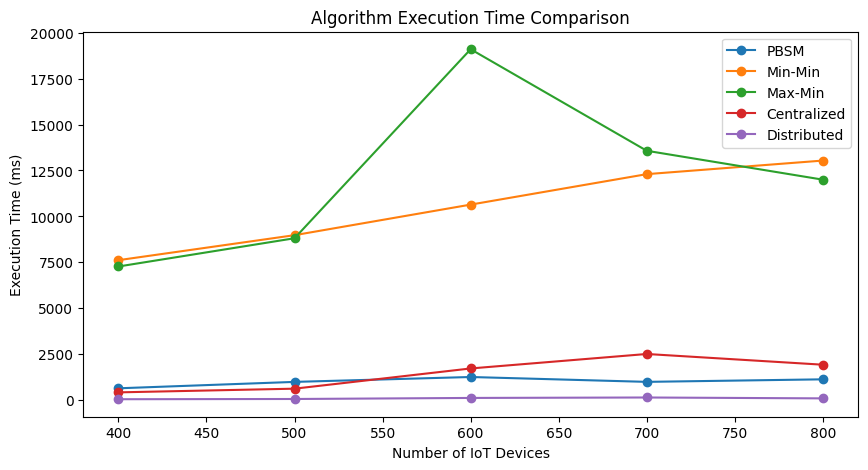

In [ ]:

# Run and visualize
iot_device_counts =  [400, 500, 600, 700, 800]
edge_node_count = 110

results = []
for iot_count in iot_device_counts:
    results.append(run_all_algorithms(iot_count, edge_node_count)[0])

plt.figure(figsize=(10, 5))
for algo in results[0].keys():
    plt.plot(iot_device_counts, [res[algo] * 10000 for res in results], marker="o", label=algo)
plt.xlabel("Number of IoT Devices")
plt.ylabel("Execution Time (ms)")
plt.title("Algorithm Execution Time Comparison")
plt.legend()
plt.show()

🔄 Edge resources reset to initial values (CPU, RAM).
Starting PBSM Algorithm...
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
Starting PBSM Algorithm...
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
Starting PBSM Algorithm...
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
Starting PBSM Algorithm...
🔄 Edge resources reset to initial values (CP

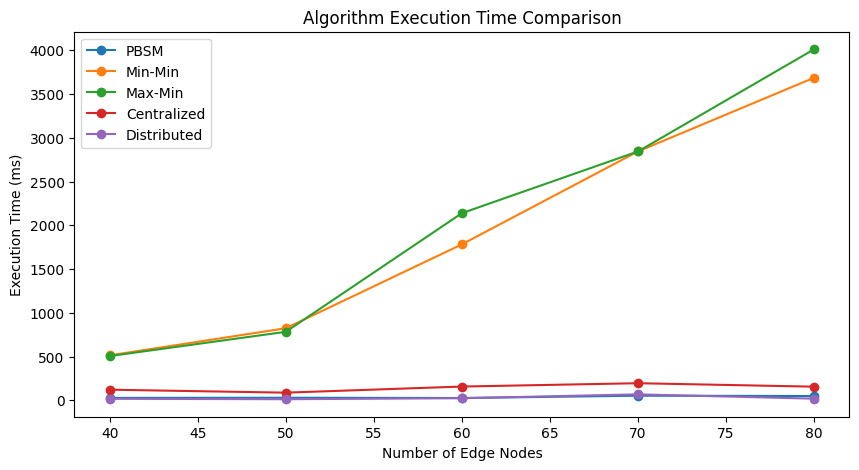

In [ ]:
# Run and visualize with IoT devices fixed to 200 and edge node count as [10, 20, 30, 40, 50]

iot_device_count = 200  # Fixed number of IoT devices
edge_node_counts = [40, 50, 60, 70, 80]  # Varying edge nodes

results = []
for edge_node_count in edge_node_counts:
    results.append(run_all_algorithms(iot_device_count, edge_node_count)[0])

plt.figure(figsize=(10, 5))
for algo in results[0].keys():
    plt.plot(edge_node_counts, [res[algo] * 10000 for res in results], marker="o", label=algo)
plt.xlabel("Number of Edge Nodes")
plt.ylabel("Execution Time (ms)")
plt.title("Algorithm Execution Time Comparison")
plt.legend()
plt.show()


🔄 Edge resources reset to initial values (CPU, RAM).
Starting PBSM Algorithm...
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
Starting PBSM Algorithm...
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
Starting PBSM Algorithm...
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
Starting PBSM Algorithm...
🔄 Edge resources reset to initial values (CP

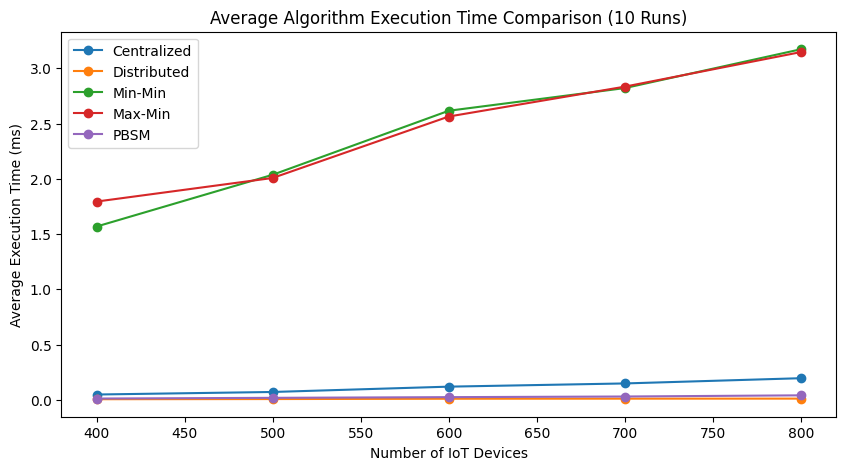

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Number of runs for each test
num_runs = 10

# Initialize lists to store the execution times for each algorithm
execution_times = {algo: [] for algo in ["Centralized", "Distributed", "Min-Min", "Max-Min", "PBSM"]}

# Run the algorithms for each IoT device count and store execution times
iot_device_counts = [400, 500, 600, 700, 800]
edge_node_count = 110

for iot_count in iot_device_counts:
    # Run the algorithms 10 times
    run_results = {algo: [] for algo in ["Centralized", "Distributed", "Min-Min", "Max-Min", "PBSM"]}

    for _ in range(num_runs):
        # Run the algorithms and store the execution time for each
        result,nn = run_all_algorithms(iot_count, edge_node_count)

        for algo in run_results.keys():
            run_results[algo].append(result[algo])

    # Calculate the average execution time for each algorithm
    for algo in run_results.keys():
        average_time = np.mean(run_results[algo])
        execution_times[algo].append(average_time)

# Now plotting the results
plt.figure(figsize=(10, 5))

# Plot the average execution time for each algorithm
for algo in execution_times.keys():
    plt.plot(iot_device_counts, execution_times[algo], marker="o", label=algo)

plt.xlabel("Number of IoT Devices")
plt.ylabel("Average Execution Time (ms)")
plt.title("Average Algorithm Execution Time Comparison (10 Runs)")
plt.legend()
plt.show()


🔄 Edge resources reset to initial values (CPU, RAM).
Starting PBSM Algorithm...
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
Starting PBSM Algorithm...
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
Starting PBSM Algorithm...
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
Starting PBSM Algorithm...
🔄 Edge resources reset to initial values (CP

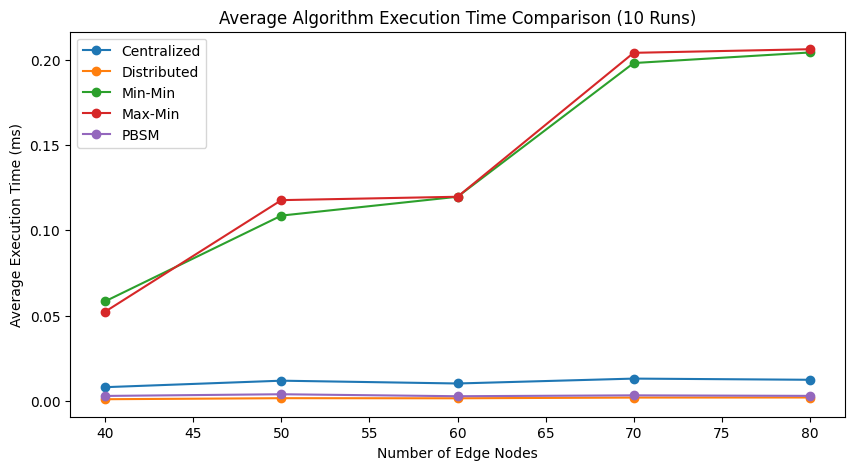

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Number of runs for each test
num_runs = 10

# Initialize lists to store the execution times for each algorithm
execution_times = {algo: [] for algo in ["Centralized", "Distributed", "Min-Min", "Max-Min", "PBSM"]}

iot_device_count = 200  # Fixed number of IoT devices
edge_node_counts = [40, 50, 60, 70, 80]  # Varying edge nodes

for edge_node_count in edge_node_counts:    # Run the algorithms 10 times
    run_results = {algo: [] for algo in ["Centralized", "Distributed", "Min-Min", "Max-Min", "PBSM"]}

    for _ in range(num_runs):
        # Run the algorithms and store the execution time for each
        result,nn = run_all_algorithms(iot_device_count, edge_node_count)

        for algo in run_results.keys():
            run_results[algo].append(result[algo])

    # Calculate the average execution time for each algorithm
    for algo in run_results.keys():
        average_time = np.mean(run_results[algo])
        execution_times[algo].append(average_time)

# Now plotting the results
plt.figure(figsize=(10, 5))

# Plot the average execution time for each algorithm
for algo in execution_times.keys():
    plt.plot(edge_node_counts, execution_times[algo], marker="o", label=algo)



plt.xlabel("Number of Edge Nodes")
plt.ylabel("Average Execution Time (ms)")
plt.title("Average Algorithm Execution Time Comparison (10 Runs)")
plt.legend()
plt.show()


🔄 Edge resources reset to initial values (CPU, RAM).
Starting PBSM Algorithm...
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).
🔄 Edge resources reset to initial values (CPU, RAM).


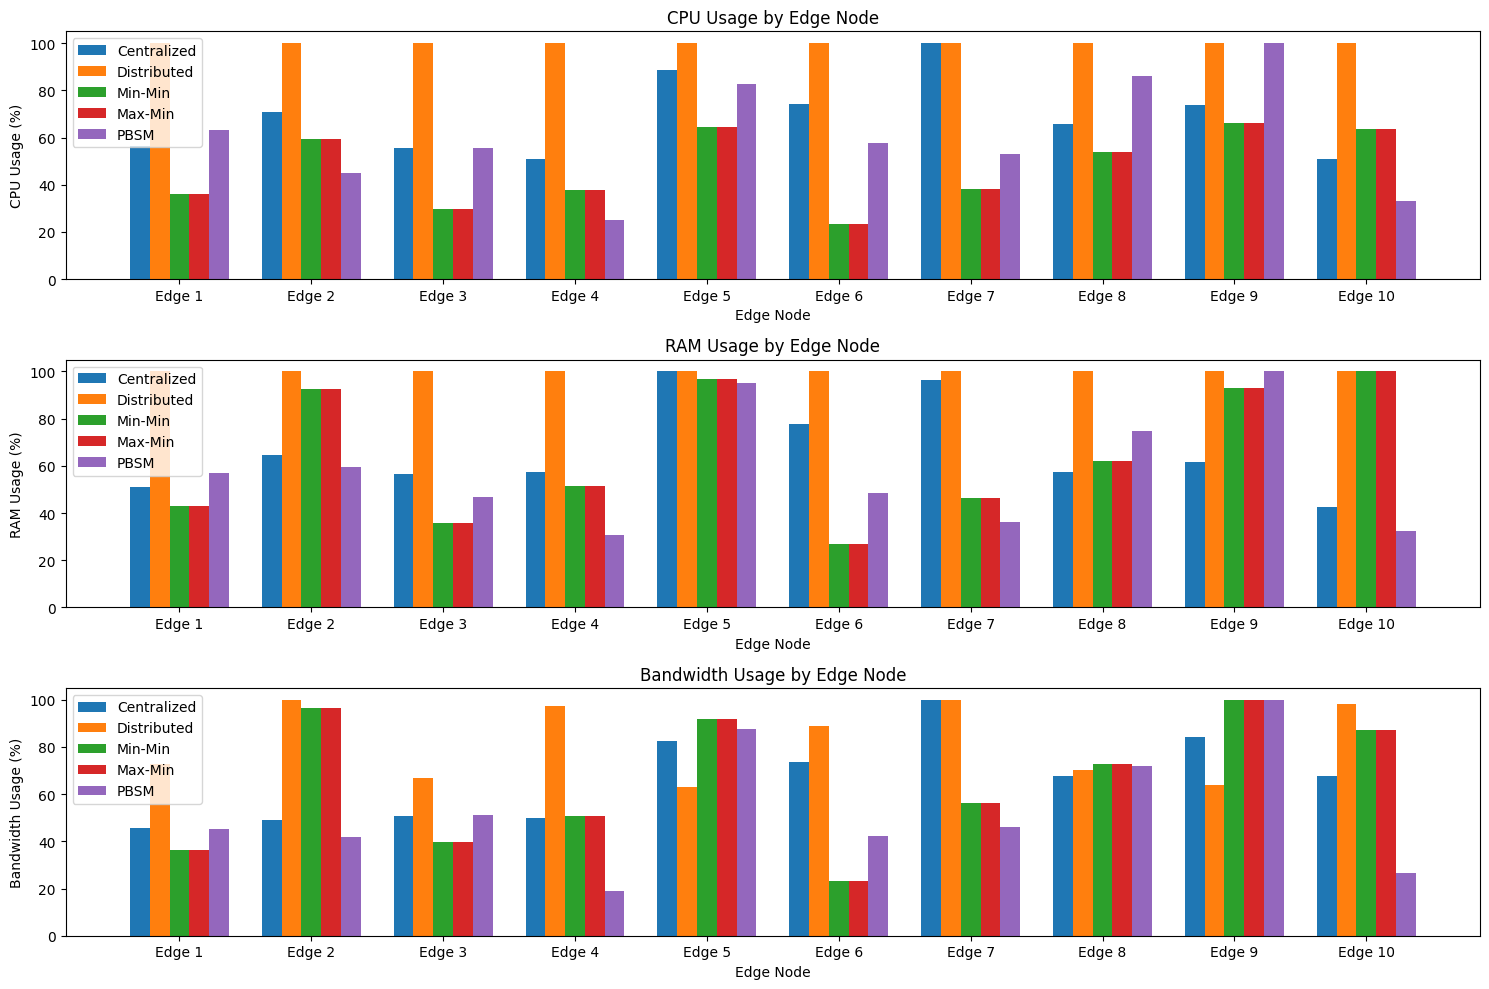

In [ ]:
iot_device_count = 100  # Fixed number of IoT devices
edge_node_count = 20  # Fixed number of edge nodes

# Global variables to store resource usage for each edge node and algorithm
cpu_usage_per_edge = {i: {"Centralized": 0, "Distributed": 0, "Min-Min": 0, "Max-Min": 0, "PBSM": 0} for i in range(edge_node_count)}
ram_usage_per_edge = {i: {"Centralized": 0, "Distributed": 0, "Min-Min": 0, "Max-Min": 0, "PBSM": 0} for i in range(edge_node_count)}
bandwidth_usage_per_edge = {i: {"Centralized": 0, "Distributed": 0, "Min-Min": 0, "Max-Min": 0, "PBSM": 0} for i in range(edge_node_count)}

# Run all algorithms and collect the results
results, edge_nodes = run_all_algorithms(iot_device_count, edge_node_count)

# Now plotting the results for each edge node's CPU, RAM, and bandwidth usage for every 10th edge node
plt.figure(figsize=(15, 10))

# CPU Usage
plt.subplot(311)
bar_width = 0.15  # width of the bars
index = np.arange(10)  # positions for 10 edge nodes

for i, algo in enumerate(cpu_usage_per_edge[0].keys()):
    max_value = max(cpu_usage_per_edge[j][algo] for j in range(edge_node_count))
    # Each algorithm's usage data is plotted as bars
    plt.bar(index + i * bar_width,
            [(cpu_usage_per_edge[edge_id][algo] / max_value) * 100 for edge_id in range(10)],
            bar_width,
            label=algo)

plt.title("CPU Usage by Edge Node")
plt.xlabel("Edge Node")
plt.ylabel("CPU Usage (%)")
plt.xticks(index + bar_width * 2, [f"Edge {i + 1}" for i in range(10)])  # Adjust X-axis labels
plt.legend()

# RAM Usage
plt.subplot(312)
for i, algo in enumerate(ram_usage_per_edge[0].keys()):
    max_value = max(ram_usage_per_edge[j][algo] for j in range(10))
    plt.bar(index + i * bar_width,
            [(ram_usage_per_edge[edge_id][algo] / max_value) * 100 for edge_id in range(10)],
            bar_width,
            label=algo)

plt.title("RAM Usage by Edge Node")
plt.xlabel("Edge Node")
plt.ylabel("RAM Usage (%)")
plt.xticks(index + bar_width * 2, [f"Edge {i + 1}" for i in range(10)])  # Adjust X-axis labels
plt.legend()

# Bandwidth Usage
plt.subplot(313)
for i, algo in enumerate(bandwidth_usage_per_edge[0].keys()):
    max_value = max(bandwidth_usage_per_edge[j][algo] for j in range(10))
    plt.bar(index + i * bar_width,
            [(bandwidth_usage_per_edge[edge_id][algo] / max_value) * 100 for edge_id in range(10)],
            bar_width,
            label=algo)

plt.title("Bandwidth Usage by Edge Node")
plt.xlabel("Edge Node")
plt.ylabel("Bandwidth Usage (%)")
plt.xticks(index + bar_width * 2, [f"Edge {i + 1}" for i in range(10)])  # Adjust X-axis labels
plt.legend()

plt.tight_layout()
plt.show()

🔄 Edge resources reset to initial values (CPU, RAM).
Starting PBSM Algorithm...
✅ IoT Device 62 assigned to Edge Node 13
✅ IoT Device 158 assigned to Edge Node 32
✅ IoT Device 18 assigned to Edge Node 50
✅ IoT Device 141 assigned to Edge Node 4
✅ IoT Device 100 assigned to Edge Node 59
✅ IoT Device 126 assigned to Edge Node 56
✅ IoT Device 14 assigned to Edge Node 38
✅ IoT Device 159 assigned to Edge Node 0
✅ IoT Device 80 assigned to Edge Node 9
✅ IoT Device 51 assigned to Edge Node 52
✅ IoT Device 105 assigned to Edge Node 18
✅ IoT Device 132 assigned to Edge Node 67
✅ IoT Device 177 assigned to Edge Node 48
✅ IoT Device 47 assigned to Edge Node 2
✅ IoT Device 189 assigned to Edge Node 42
✅ IoT Device 99 assigned to Edge Node 37
✅ IoT Device 101 assigned to Edge Node 33
✅ IoT Device 104 assigned to Edge Node 85
✅ IoT Device 157 assigned to Edge Node 84
✅ IoT Device 82 assigned to Edge Node 86
🔄 IoT Device 110 swapped with IoT Device 132 for Edge Node 67
✅ IoT Device 161 assigned to E

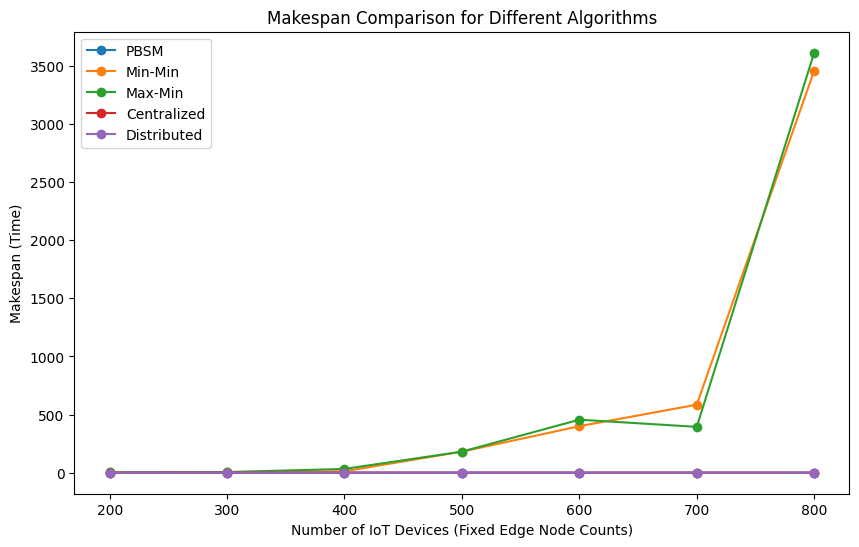

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import pandas as pd
from tqdm import tqdm

# Global variables to store resource usage for each edge node and algorithm

# Run the algorithms for different IoT device counts and edge node counts
iot_device_counts = [200, 300, 400, 500, 600, 700, 800]
edge_node_counts = [100]


edge_node_count = 100
cpu_usage_per_edge = {i: {"Centralized": 0, "Distributed": 0, "Min-Min": 0, "Max-Min": 0, "PBSM": 0} for i in range(edge_node_count)}
ram_usage_per_edge = {i: {"Centralized": 0, "Distributed": 0, "Min-Min": 0, "Max-Min": 0, "PBSM": 0} for i in range(edge_node_count)}
bandwidth_usage_per_edge = {i: {"Centralized": 0, "Distributed": 0, "Min-Min": 0, "Max-Min": 0, "PBSM": 0} for i in range(edge_node_count)}


def calculate_makespan(iot_devices, edge_nodes):
    task_completion_times = []

    for node in edge_nodes:
        node_tasks = [task for task in iot_devices if task.get('assigned_node') == node['id']]
        total_time = 0
        for task in node_tasks:
            if node['available_cpu'] == 0:
                print(f"⚠️ Node {node['id']} has 0 available CPU, skipping task {task['id']}!")
                continue  # Skip the task if the node has no available CPU
            task_time = task['cpu'] / node['available_cpu']
            total_time += task_time
        task_completion_times.append(total_time)

    return max(task_completion_times)


def run_all_algorithms_span(iot_count, edge_count):
    edge_nodes = initialize_edge_nodes(edge_count)
    iot_devices = initialize_iot_devices(iot_count, edge_nodes)

    for device in iot_devices:
        device["preferences"] = generate_iot_preferences(device, edge_nodes)

    for node in edge_nodes:
        node["preferences"] = generate_edge_preferences(node, iot_devices)

    results = {}

    # Run PBSM Algorithm
    reset_edge_resources(edge_nodes, iot_devices)
    pbsm_start = time.perf_counter()
    pbsm_algorithm(iot_devices, edge_nodes)
    pbsm_time = time.perf_counter() - pbsm_start
    print("check")
    results["PBSM"] = calculate_makespan(iot_devices, edge_nodes)

    # Run Min-Min Algorithm
    print("min-min")
    reset_edge_resources(edge_nodes, iot_devices)
    min_min_start = time.perf_counter()
    min_min_matching(iot_devices, edge_nodes)
    min_min_time = time.perf_counter() - min_min_start
    results["Min-Min"] = calculate_makespan(iot_devices, edge_nodes)

    # Run Max-Min Algorithm
    print("max min")
    reset_edge_resources(edge_nodes, iot_devices)
    max_min_start = time.perf_counter()
    max_min_matching(iot_devices, edge_nodes)
    max_min_time = time.perf_counter() - max_min_start
    results["Max-Min"] = calculate_makespan(iot_devices, edge_nodes)

    # Run Centralized Algorithm
    reset_edge_resources(edge_nodes, iot_devices)
    centralized_start = time.perf_counter()
    centralized_matching(edge_nodes, iot_devices)
    centralized_time = time.perf_counter() - centralized_start
    results["Centralized"] = calculate_makespan(iot_devices, edge_nodes)

    # Run Distributed Algorithm
    reset_edge_resources(edge_nodes, iot_devices)
    distributed_start = time.perf_counter()
    send_proposals(iot_devices, edge_nodes)
    process_proposals(edge_nodes)
    distributed_time = time.perf_counter() - distributed_start
    results["Distributed"] = calculate_makespan(iot_devices, edge_nodes)

    return results


makespan_results = {algo: [] for algo in ["PBSM", "Min-Min", "Max-Min", "Centralized", "Distributed"]}

# Run the algorithms for each combination of IoT devices and edge nodes
for edge_count in edge_node_counts:
    for iot_count in iot_device_counts:
        results = run_all_algorithms_span(iot_count, edge_count)

        for algo, makespan in results.items():
            makespan_results[algo].append(makespan)

# Plotting the makespan results for different IoT devices counts and edge node counts
plt.figure(figsize=(10, 6))

for algo in makespan_results:
    plt.plot(iot_device_counts * len(edge_node_counts), makespan_results[algo], marker="o", label=algo)

plt.xlabel("Number of IoT Devices (Fixed Edge Node Counts)")
plt.ylabel("Makespan (Time)")
plt.title("Makespan Comparison for Different Algorithms")
plt.legend()
plt.show()


Streaming output truncated to the last 5000 lines.
✅ IoT Device 297 assigned to Edge Node 78
🔄 IoT Device 605 swapped with IoT Device 402 for Edge Node 21
✅ IoT Device 221 assigned to Edge Node 40
✅ IoT Device 403 assigned to Edge Node 44
✅ IoT Device 46 assigned to Edge Node 79
🔄 IoT Device 6 swapped with IoT Device 625 for Edge Node 89
✅ IoT Device 690 assigned to Edge Node 88
🔄 IoT Device 203 swapped with IoT Device 673 for Edge Node 75
🔄 IoT Device 68 swapped with IoT Device 203 for Edge Node 75
🔄 IoT Device 513 swapped with IoT Device 590 for Edge Node 13
🔄 IoT Device 477 swapped with IoT Device 429 for Edge Node 19
🔄 IoT Device 653 swapped with IoT Device 250 for Edge Node 65
✅ IoT Device 85 assigned to Edge Node 95
🔄 IoT Device 555 swapped with IoT Device 699 for Edge Node 42
🔄 IoT Device 422 swapped with IoT Device 161 for Edge Node 18
✅ IoT Device 100 assigned to Edge Node 46
🔄 IoT Device 447 swapped with IoT Device 291 for Edge Node 45
🔄 IoT Device 492 swapped with IoT Device

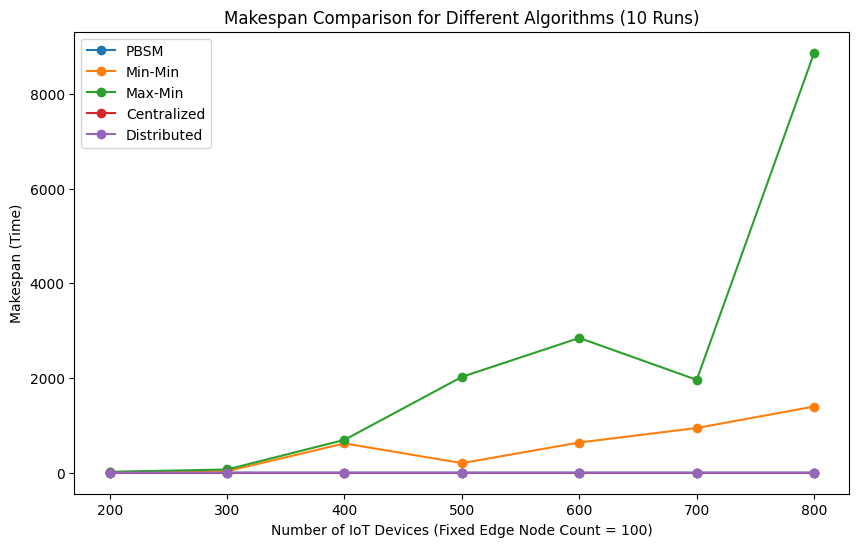

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import pandas as pd
from tqdm import tqdm

# Global variables to store resource usage for each edge node and algorithm
edge_node_count = 100
cpu_usage_per_edge = {i: {"Centralized": 0, "Distributed": 0, "Min-Min": 0, "Max-Min": 0, "PBSM": 0} for i in range(edge_node_count)}
ram_usage_per_edge = {i: {"Centralized": 0, "Distributed": 0, "Min-Min": 0, "Max-Min": 0, "PBSM": 0} for i in range(edge_node_count)}
bandwidth_usage_per_edge = {i: {"Centralized": 0, "Distributed": 0, "Min-Min": 0, "Max-Min": 0, "PBSM": 0} for i in range(edge_node_count)}

iot_device_counts = [200, 300, 400, 500, 600, 700, 800]  # Range of IoT device counts
edge_node_counts = [100]  # Fixed number of edge nodes

# Store results
makespan_results = {algo: [] for algo in ["PBSM", "Min-Min", "Max-Min", "Centralized", "Distributed"]}

# Run the experiments 10 times and average the results
for edge_count in edge_node_counts:
    for iot_count in iot_device_counts:
        algo_results = {algo: [] for algo in ["PBSM", "Min-Min", "Max-Min", "Centralized", "Distributed"]}

        # Run 10 times for each combination
        for _ in range(10):
            results = run_all_algorithms_span(iot_count, edge_count)

            # Collect the makespan for each algorithm
            for algo, makespan in results.items():
                algo_results[algo].append(makespan)

        # Calculate the average makespan for each algorithm
        for algo in algo_results:
            avg_makespan = np.mean(algo_results[algo])
            makespan_results[algo].append(avg_makespan)

# Plotting the makespan results for different IoT devices counts and edge node counts
plt.figure(figsize=(10, 6))

for algo in makespan_results:
    plt.plot(iot_device_counts * len(edge_node_counts), makespan_results[algo], marker="o", label=algo)

plt.xlabel("Number of IoT Devices (Fixed Edge Node Count = 100)")
plt.ylabel("Makespan (Time)")
plt.title("Makespan Comparison for Different Algorithms (10 Runs)")
plt.legend()
plt.show()


🔄 Edge resources reset to initial values (CPU, RAM).
Starting PBSM Algorithm...
✅ IoT Device 53 assigned to Edge Node 8
🔄 IoT Device 63 swapped with IoT Device 53 for Edge Node 8
✅ IoT Device 74 assigned to Edge Node 2
✅ IoT Device 84 assigned to Edge Node 14
✅ IoT Device 23 assigned to Edge Node 19
✅ IoT Device 26 assigned to Edge Node 4
✅ IoT Device 78 assigned to Edge Node 18
🔄 IoT Device 27 swapped with IoT Device 23 for Edge Node 19
🔄 IoT Device 66 swapped with IoT Device 74 for Edge Node 2
✅ IoT Device 70 assigned to Edge Node 6
🔄 IoT Device 40 swapped with IoT Device 26 for Edge Node 4
🔄 IoT Device 18 swapped with IoT Device 70 for Edge Node 6
✅ IoT Device 19 assigned to Edge Node 9
✅ IoT Device 91 assigned to Edge Node 3
✅ IoT Device 51 assigned to Edge Node 11
✅ IoT Device 92 assigned to Edge Node 1
✅ IoT Device 72 assigned to Edge Node 0
✅ IoT Device 56 assigned to Edge Node 12
✅ IoT Device 20 assigned to Edge Node 17
🔄 IoT Device 93 swapped with IoT Device 78 for Edge Node 1

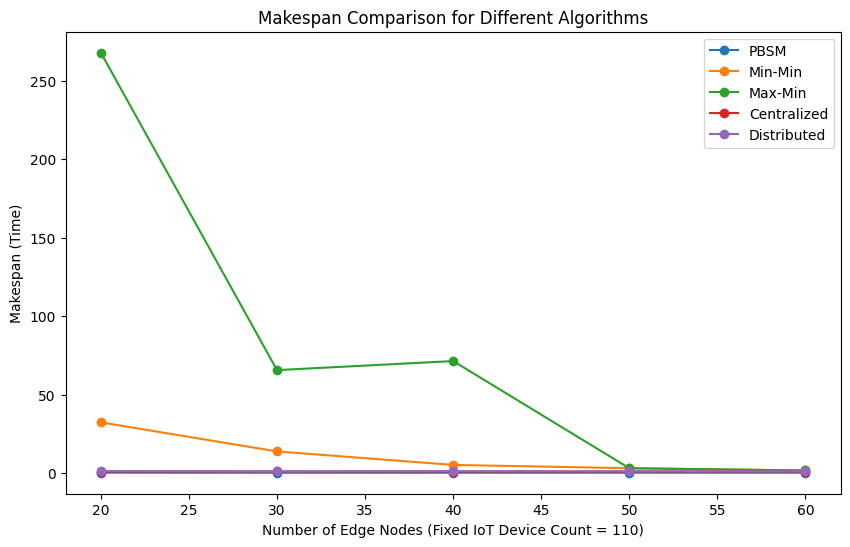

In [ ]:
# Run the algorithms for different IoT device counts and edge node counts
iot_device_counts = [110]  # Fixed number of IoT devices
edge_node_counts = [20, 30, 40, 50, 60]  # Range of edge nodes

makespan_results = {algo: [] for algo in ["PBSM", "Min-Min", "Max-Min", "Centralized", "Distributed"]}

# Run the algorithms for each combination of IoT devices and edge nodes
for edge_count in edge_node_counts:
    for iot_count in iot_device_counts:
        results = run_all_algorithms_span(iot_count, edge_count)

        for algo, makespan in results.items():
            makespan_results[algo].append(makespan)

# Plotting the makespan results for different edge node counts and IoT devices
plt.figure(figsize=(10, 6))

for algo in makespan_results:
    plt.plot(edge_node_counts * len(iot_device_counts), makespan_results[algo], marker="o", label=algo)

plt.xlabel("Number of Edge Nodes (Fixed IoT Device Count = 110)")
plt.ylabel("Makespan (Time)")
plt.title("Makespan Comparison for Different Algorithms")
plt.legend()
plt.show()


🔄 Edge resources reset to initial values (CPU, RAM).
Starting PBSM Algorithm...
✅ IoT Device 0 assigned to Edge Node 4
✅ IoT Device 76 assigned to Edge Node 6
✅ IoT Device 108 assigned to Edge Node 15
✅ IoT Device 58 assigned to Edge Node 9
✅ IoT Device 57 assigned to Edge Node 19
✅ IoT Device 35 assigned to Edge Node 12
✅ IoT Device 65 assigned to Edge Node 3
✅ IoT Device 60 assigned to Edge Node 5
✅ IoT Device 99 assigned to Edge Node 2
✅ IoT Device 67 assigned to Edge Node 14
🔄 IoT Device 12 swapped with IoT Device 67 for Edge Node 14
✅ IoT Device 61 assigned to Edge Node 17
✅ IoT Device 37 assigned to Edge Node 7
🔄 IoT Device 23 swapped with IoT Device 12 for Edge Node 14
🔄 IoT Device 90 swapped with IoT Device 108 for Edge Node 15
✅ IoT Device 5 assigned to Edge Node 8
🔄 IoT Device 87 swapped with IoT Device 65 for Edge Node 3
🔄 IoT Device 106 swapped with IoT Device 58 for Edge Node 9
🔄 IoT Device 41 swapped with IoT Device 76 for Edge Node 6
✅ IoT Device 81 assigned to Edge Node

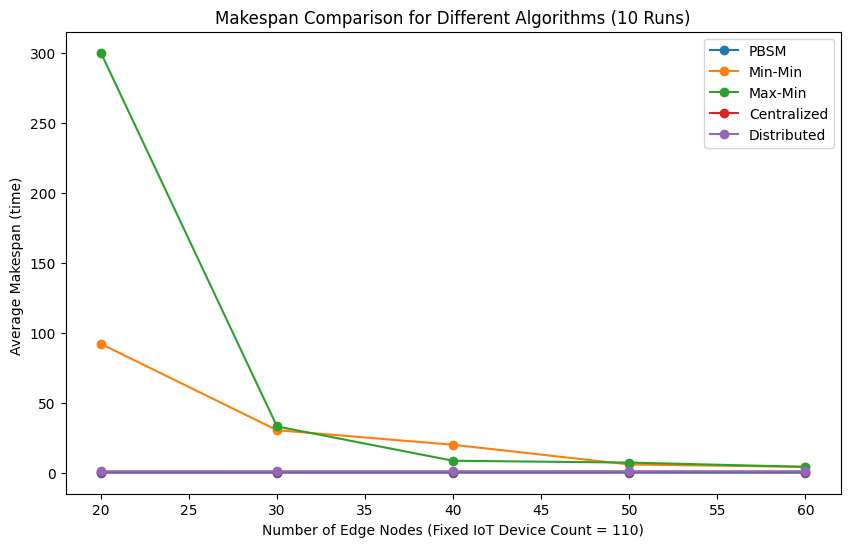

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Run the algorithms for different IoT device counts and edge node counts
iot_device_counts = [110]  # Fixed number of IoT devices
edge_node_counts = [20, 30, 40, 50, 60]  # Range of edge nodes

makespan_results = {algo: [] for algo in ["PBSM", "Min-Min", "Max-Min", "Centralized", "Distributed"]}

# Run the algorithms for each combination of IoT devices and edge nodes, 10 times
for edge_count in edge_node_counts:
    for iot_count in iot_device_counts:
        algo_results = {algo: [] for algo in ["PBSM", "Min-Min", "Max-Min", "Centralized", "Distributed"]}

        for _ in range(10):  # Run 10 times
            results = run_all_algorithms_span(iot_count, edge_count)

            # Collect the results for each algorithm
            for algo, makespan in results.items():
                algo_results[algo].append(makespan)

        # Calculate the average makespan for each algorithm
        for algo in algo_results:
            avg_makespan = np.mean(algo_results[algo])
            makespan_results[algo].append(avg_makespan)

# Plotting the makespan results for different edge node counts and IoT devices
plt.figure(figsize=(10, 6))

for algo in makespan_results:
    plt.plot(edge_node_counts, makespan_results[algo], marker="o", label=algo)

plt.xlabel("Number of Edge Nodes (Fixed IoT Device Count = 110)")
plt.ylabel("Average Makespan (time) ")
plt.title("Makespan Comparison for Different Algorithms (10 Runs)")
plt.legend()
plt.show()
